# Day 08. Exercise 05
# Clustering

## 0. Imports

In [384]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

In [385]:
def plot_scores(scores: dict, param_name: str, ax_):
    plt_scores = sns.lineplot(data={'silhouette_score': scores.values(),
                                    param_name: scores.keys()},
                              ax=ax_, marker='o', lw=4, ms=12, color='c',
                              x=param_name, y='silhouette_score')

    plt_scores.xaxis.set_major_locator(ticker.MultipleLocator(1))
    sns.set_style("darkgrid")

    ax_.plot([list(scores.keys())[0], list(scores.keys())[0]],
             [min(scores.values()) - 1, max(scores.values()) + 1])
    
    offx = (max(scores.keys()) - min(scores.keys())) / len(scores.keys())
    offy = (max(scores.values()) - min(scores.values())) / len(scores.keys())
    plt_scores.set_xlim(min(scores.keys()) - offx, max(scores.keys()) + offx)
    plt_scores.set_ylim(min(scores.values()) - offy, max(scores.values()) + offy)

In [386]:
def plot_scatter(X, labels, ax_):
    plt_scatter = sns.scatterplot(data=X, ax=ax_,
                                  x='num_commits', y='AVG(diff)', hue=labels,
                                  palette='tab10', s=100, alpha=0.9)
    plt_scatter.legend(loc='upper right')

In [387]:
def plot_best_vals(model: str, param_to_optim: str, vals_range: range, X, **params):
    if param_to_optim in params:
        del params[param_to_optim]
    model_args = ','.join(f'{key}={val}' for key, val in params.items()) + f',{param_to_optim}='
    model_args = model_args.strip(',')
    scores = {i: eval(f'silhouette_score(X, {model}({model_args}i).fit_predict(X))') for i in vals_range}
    scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
    
    fig_, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))
    plot_scores(scores, param_to_optim, ax1)
    
    best_case_labels = eval(f'{model}({model_args}{list(scores.keys())[0]}).fit_predict(X)')
    plot_scatter(X, best_case_labels, ax2)
    plt.show()

## 1. Preprocessing

1. Read the file [`regression.csv`](https://drive.google.com/file/d/1fzOPkuXoxLleOsvNVCT0m-LKxlid33ma/view?usp=sharing) to a dataframe.
2. Remove the `pageviews`, we will cluster the users only by the number of the commits and their average difference.

In [388]:
df = pd.read_csv('../data/regression.csv', index_col='uid').drop(columns=['pageviews'])
df.head()

,num_commits,AVG(diff)
uid,,
user_1,62,-64.400000
user_10,20,-74.800000
user_14,61,-159.000000
user_17,51,-61.600000
user_18,5,-5.666667


---
## 2. KMeans

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters, use `random_state=21` and `n_clusters=3`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `n_clusters` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

In [389]:
X = df[['num_commits', 'AVG(diff)']]

In [390]:
kmeans = KMeans(random_state=21, n_clusters=3)
labels = kmeans.fit_predict(X)
labels

array([1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       2, 0, 1, 0, 2, 0, 0], dtype=int32)

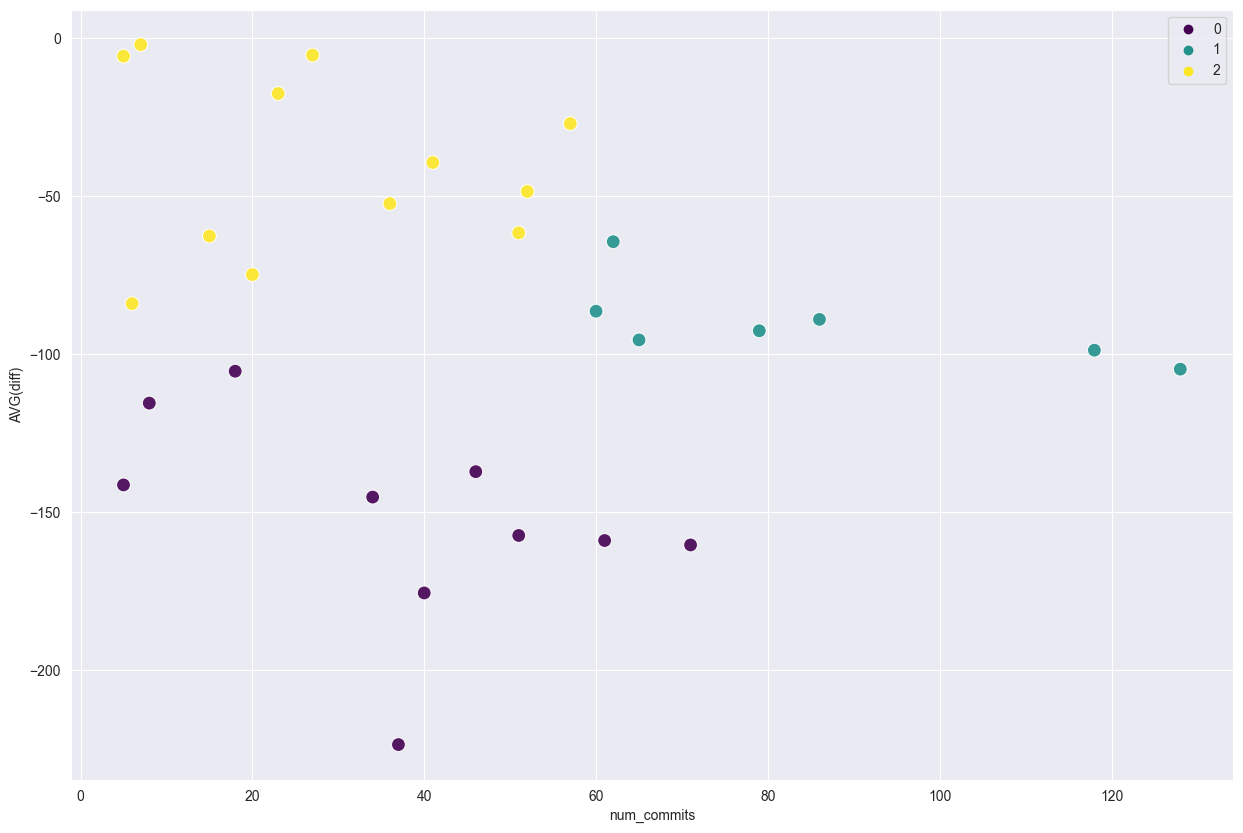

In [391]:
fig1, ax1 = plt.subplots(figsize=(15, 10))

plt_kmeans = sns.scatterplot(data=X, ax=ax1,
                             x='num_commits', y='AVG(diff)', hue=labels,
                             palette='viridis', s=100, alpha=0.9)
plt.show()

In [392]:
silhouette_score(X, labels) # for 3 clusters

0.43901709571532954

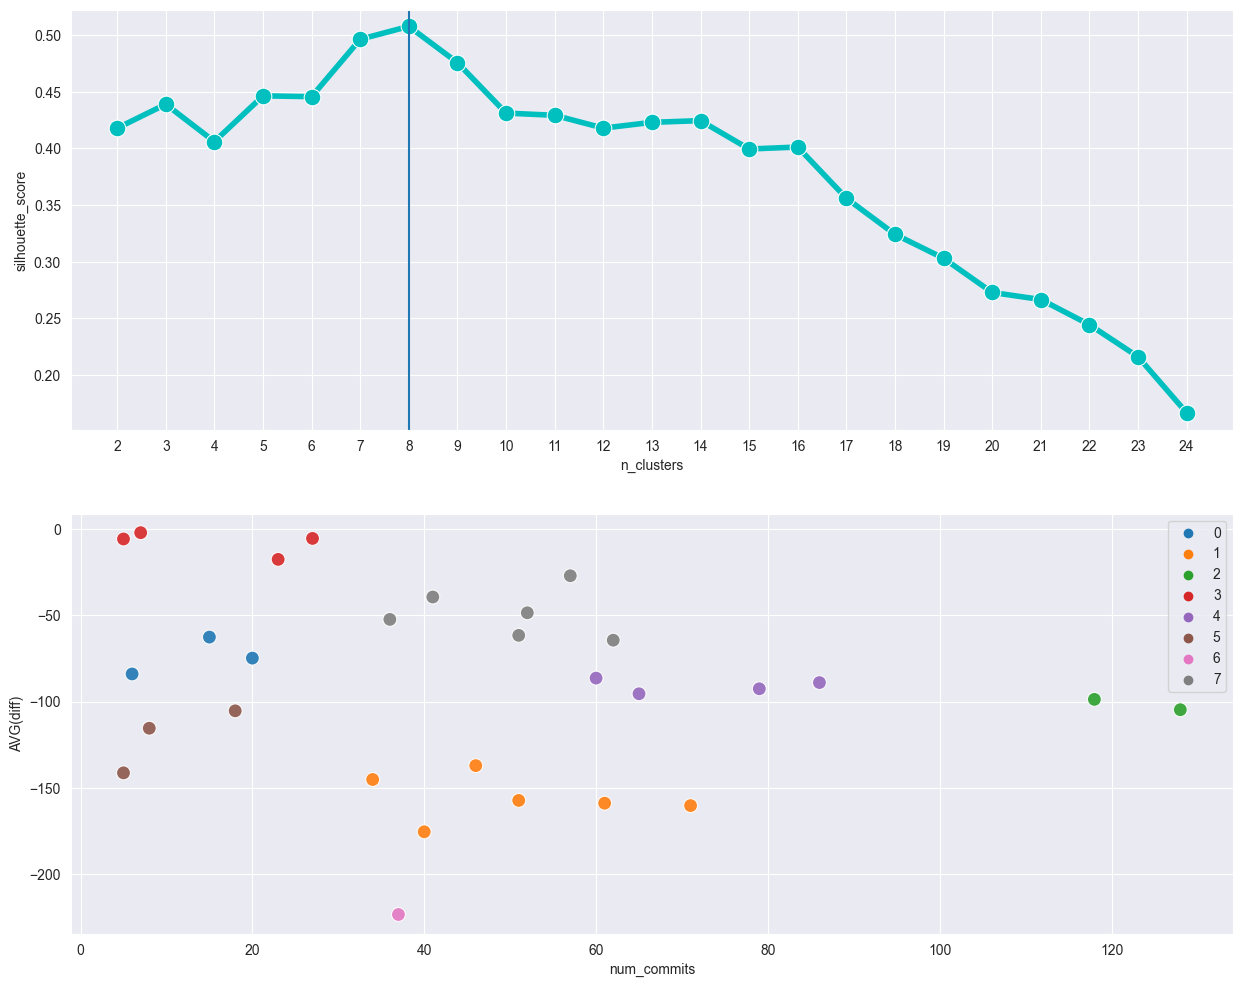

In [393]:
plot_best_vals('KMeans', 'n_clusters', range(2,25), X)

> We found out that optimal values for KMeans param `n_clusters` is `8`

---
## 3. DBSCAN

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters with `eps=20` and `min_samples=2`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `eps` and `min_samples` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

In [394]:
clastering = DBSCAN(eps=20, min_samples=2).fit_predict(X)
df['dbscan'] = clastering
clastering

array([ 0,  1,  2,  0,  3,  4,  5,  5,  5,  6,  7,  3,  5,  0,  8,  0,  7,
       -1, -1,  1, -1,  0,  8,  2,  4, -1,  1,  6,  2])

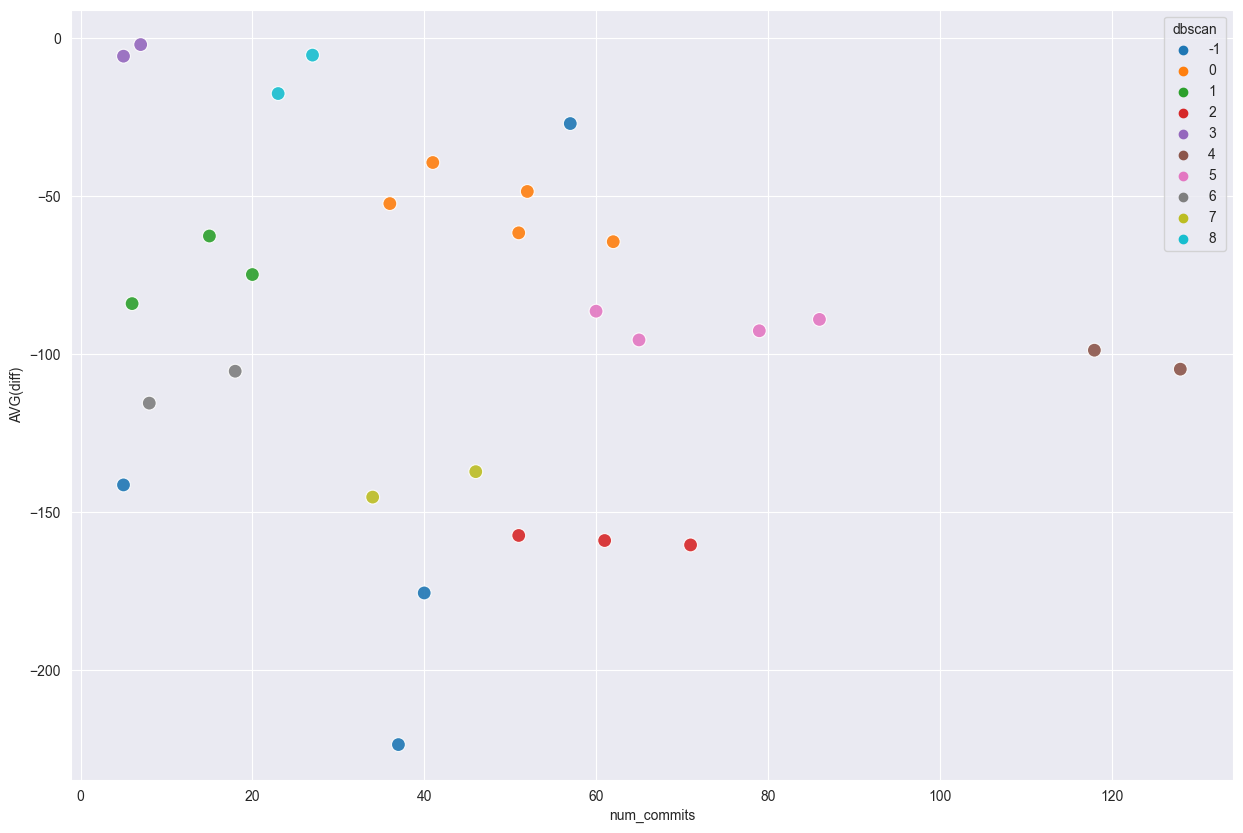

In [395]:
fig3, ax3 = plt.subplots(figsize=(15, 10))

plt_dbscan = sns.scatterplot(data=df, ax=ax3,
                             x='num_commits', y='AVG(diff)', hue='dbscan',
                             palette='tab10', s=100, alpha=0.9)
plt.show()

In [396]:
silhouette_score(X, clastering) # for eps=20, min_samples=2

0.38339641455696616

---

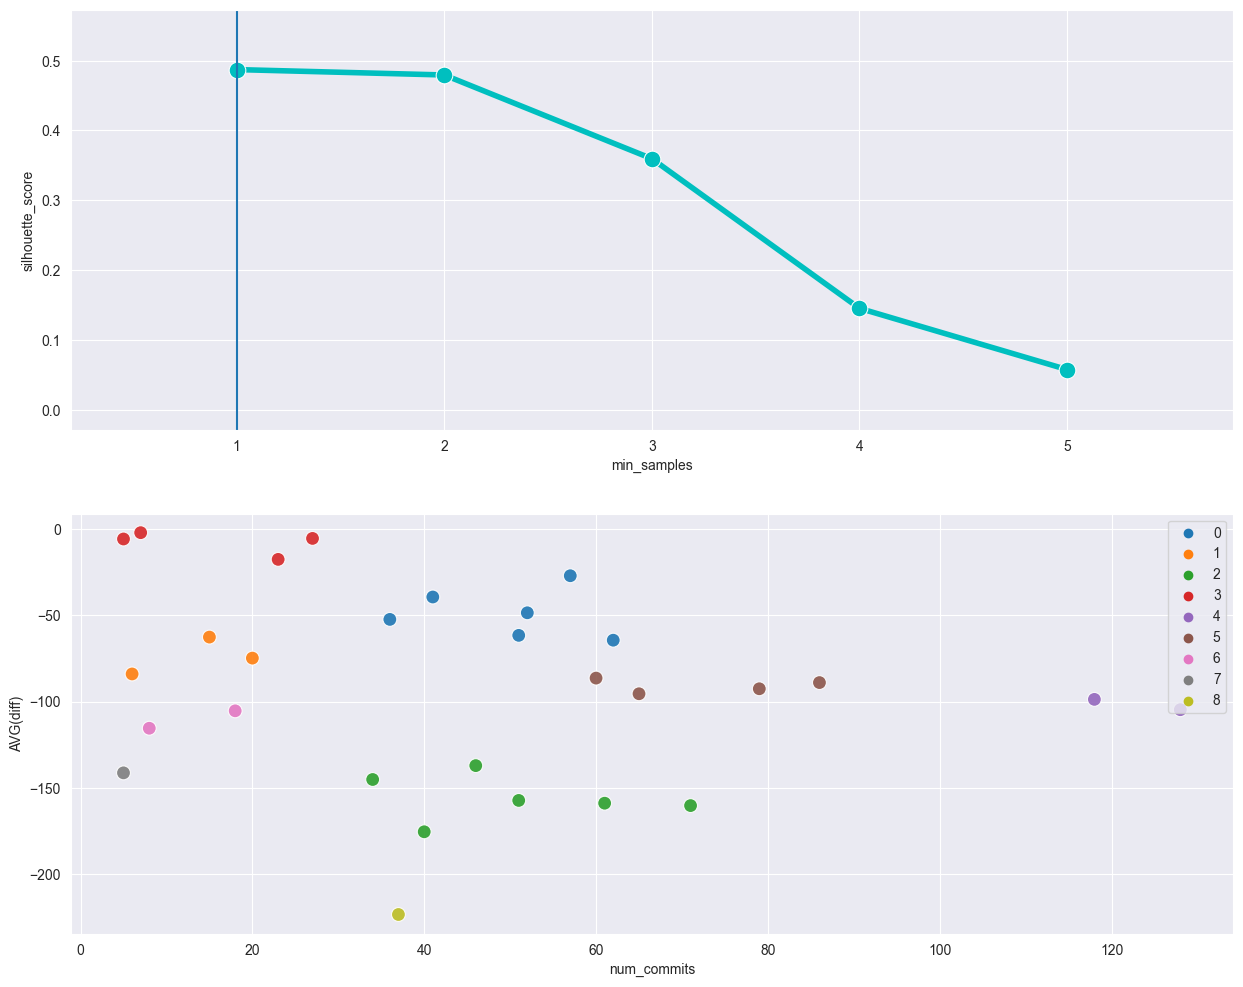

In [397]:
plot_best_vals('DBSCAN', 'min_samples', range(1,6), X, eps=22, min_samples=1)

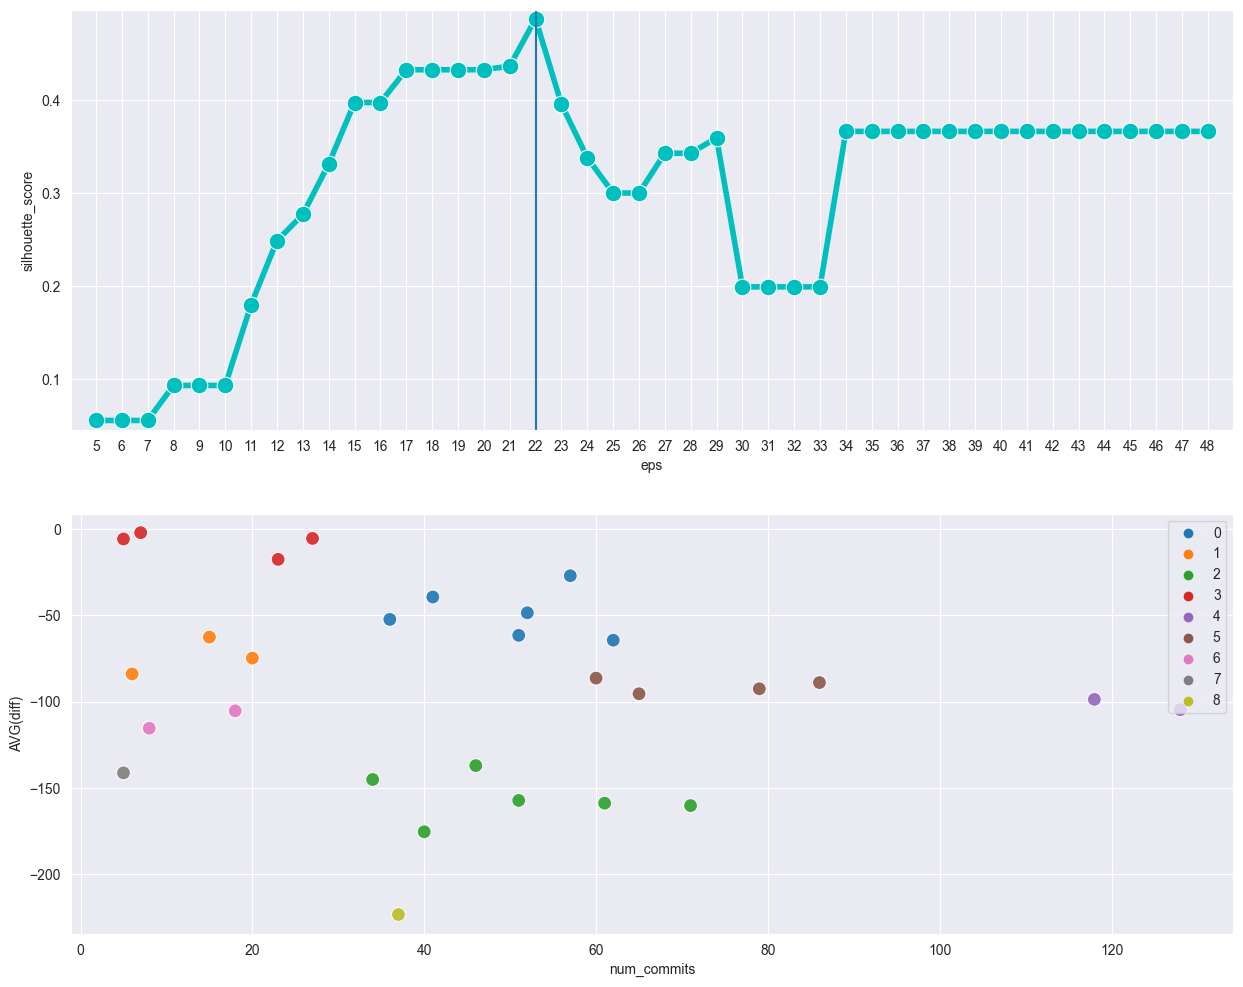

In [398]:
plot_best_vals('DBSCAN', 'eps', range(5,49), X, eps=22, min_samples=1)

> We found out that optimal values for `eps` and `min_samples` are `22` and `1`

## 4. Hierarchical (AgglomerativeClustering)

1. Use this algorithm to create clusters with `n_clusters=5`.
2. Visualize the data on a `scatter plot`.
3. Try different values of `n_clusters` and see how your plot will change.
4. Calculate the `silhouette_score`.
5. Visualize the `dendrogram`.

In [399]:
clustering_pred = AgglomerativeClustering(n_clusters=5).fit_predict(X)
df['AggCl'] = clustering_pred
clustering_pred

array([2, 3, 0, 2, 4, 1, 1, 1, 1, 3, 0, 4, 1, 2, 4, 2, 0, 2, 3, 3, 0, 2,
       4, 0, 1, 0, 3, 3, 0])

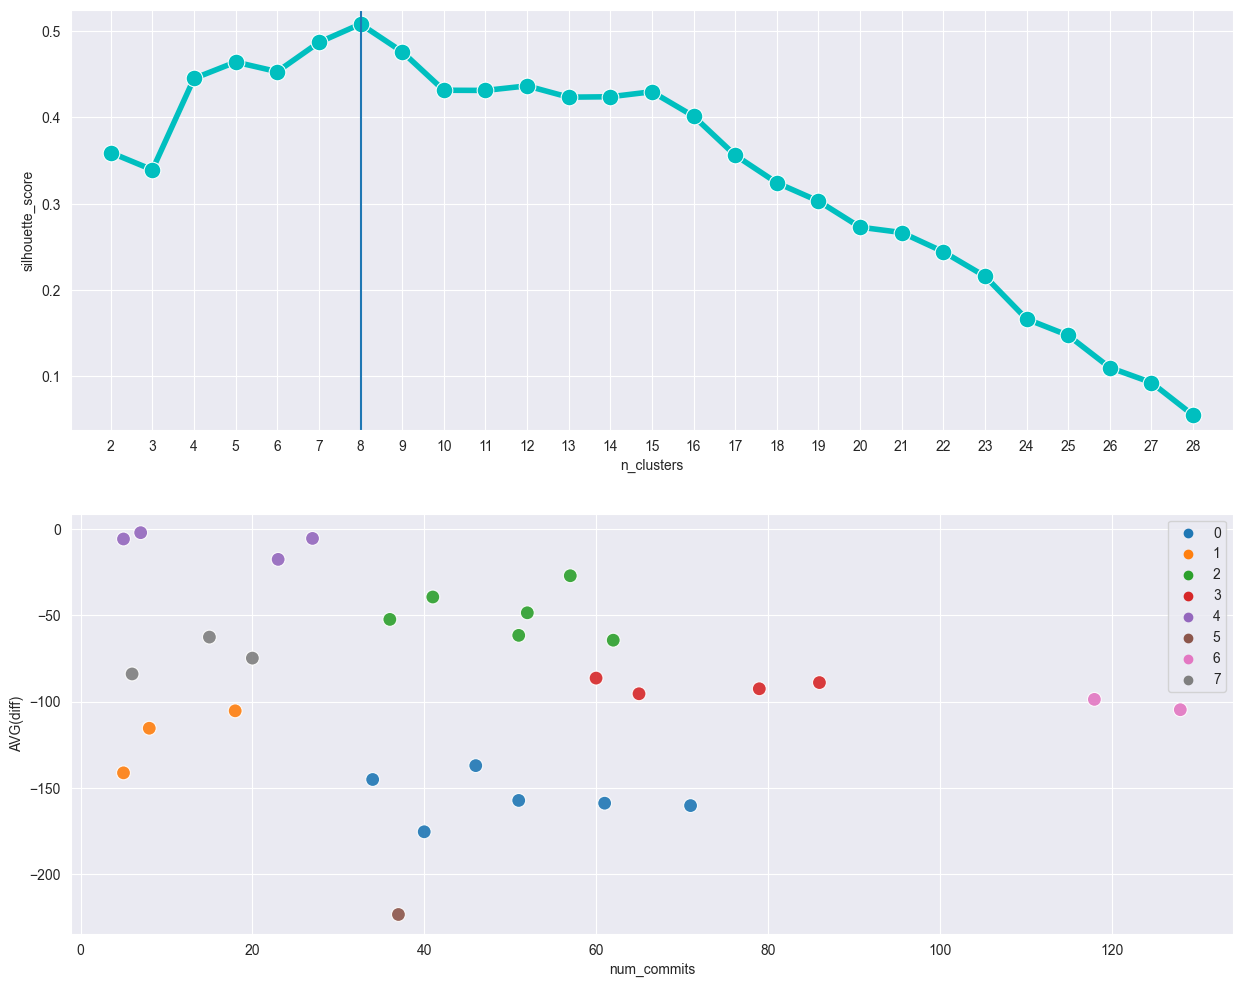

In [400]:
plot_best_vals('AgglomerativeClustering', 'n_clusters', range(2,29), X)

---
### Plotting dendogram

In [401]:
def plot_dendogram(model, ax_, **kwargs):
    children = clustering.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0] + 2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, labels=model.labels_, ax=ax_)

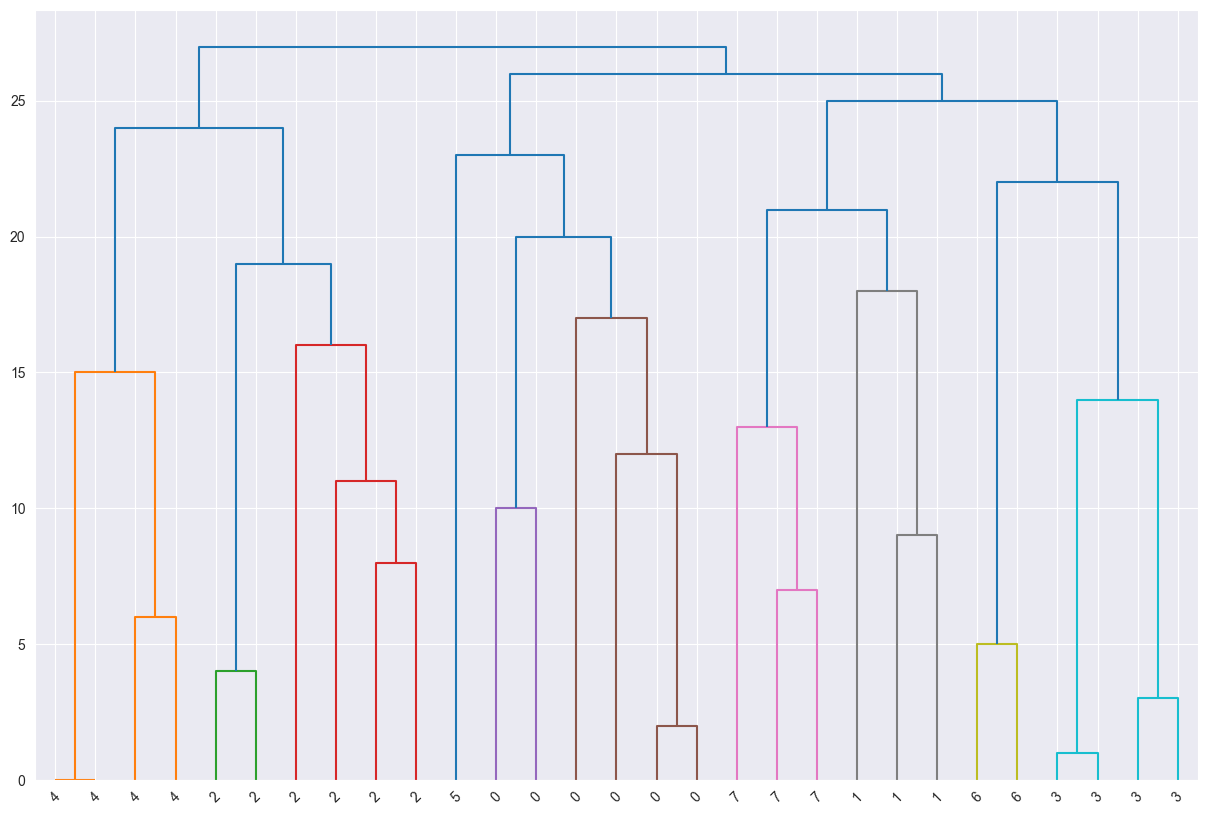

In [402]:
clustering = AgglomerativeClustering(n_clusters=8).fit(X)

fig_d, ax_d = plt.subplots(figsize=(15, 10))

plot_dendogram(clustering, ax_d, labels=clustering.labels_)
plt.show()

## 5. Function

Write a function that:
1. Takes as arguments: model class of clustering, its parameters, the name of the parameter for optimization, the range of the parameter values to try.
2. Tries different values from the given parameter range and calculates the `silhouette_score` for each value from the range.
3. Finds out the best value for the parameter in the range.
4. Returns two subplots:


- - the first shows how the `silhouette_score` changes depending on the value of the parameter,
- - the second visualizes the data on a `scatter plot` using the clustering model with the best value of the parameter.

> function implementation is at the top of notebook

In case if we wanna test `eps` parameter for `DBSCAN`, for example, but we pass it as `**kwarg` for the model, then it will be tested anyway (so it's ok)

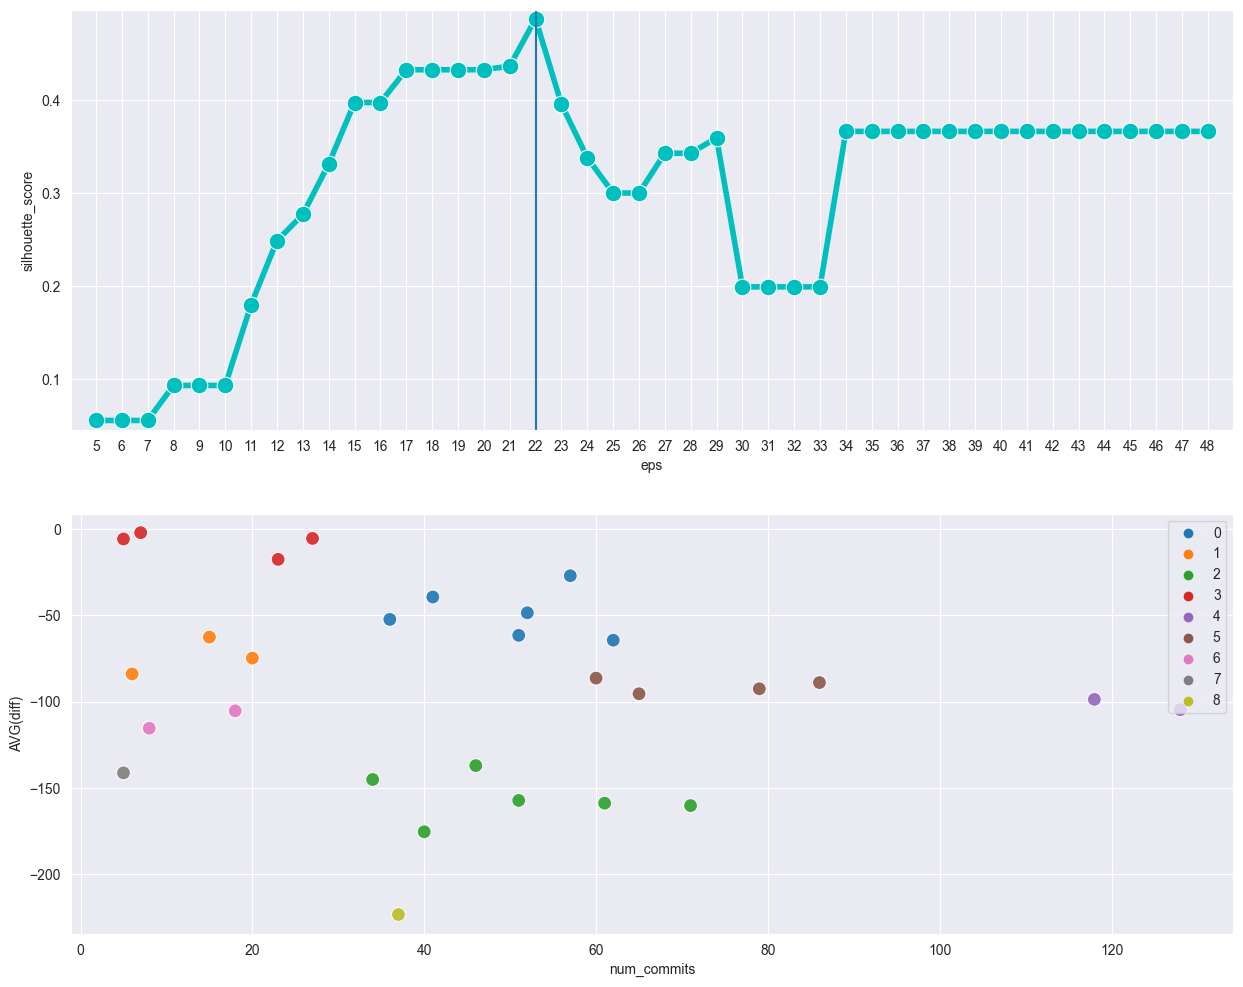

In [403]:
# for test purposes
plot_best_vals('DBSCAN', 'eps', range(5,49), X, eps=22, min_samples=1)